In [1]:
import matplotlib.pyplot as plt

from fitting import create_ensemble, load_data, create_datasets, create_quad_scan_beamline
from phase_space_reconstruction import modeling
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from bmadx.bmad_torch.track_torch import Beam
import torch

tkwargs = {"dtype": torch.float}
save_dir = "alpha_1000"
quad_strengths, image_data, bins, xx = load_data(tkwargs)
train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2
ensemble = create_ensemble(bins, bandwidth)

lattice = create_quad_scan_beamline()
diagnostic = ImageDiagnostic(bins, bandwidth=bandwidth)
# create NN beam
n_particles = 10000
nn_transformer = modeling.NNTransform(2, 20, output_scale=1e-3)
nn_beam = modeling.InitialBeam(
    nn_transformer,
    Beam(
        torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6)).sample(
            [n_particles]
        ),
        p0c=torch.tensor(10e6),
    ),
)
module_kwags = {"lattice": lattice, "diagnostic": diagnostic, "beam": nn_beam}

C:\ProgramData\Miniconda3\envs\phase_space_reconstruction\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
model = modeling.PhaseSpaceReconstructionModel(**module_kwags)

In [3]:
with torch.no_grad():
    predictions, entropy = model(train_dset[:5][0])

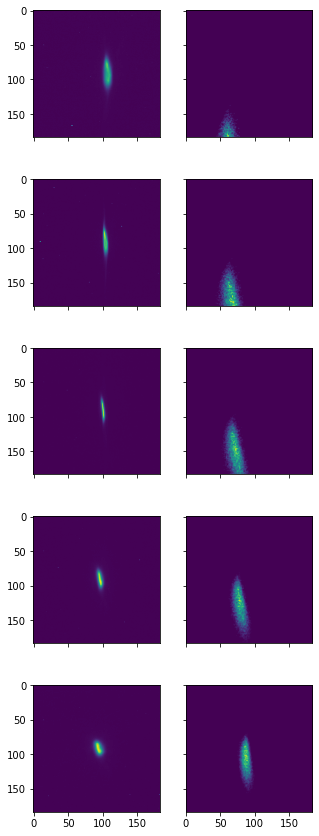

In [4]:
fig,ax = plt.subplots(len(predictions),2,sharex="all", sharey="all")
fig.set_size_inches(5,15)
for i in range(len(predictions)):
    ax[i][0].imshow(train_dset[i][1][0].cpu().detach())
    ax[i][1].imshow(predictions[i][0].cpu().detach())

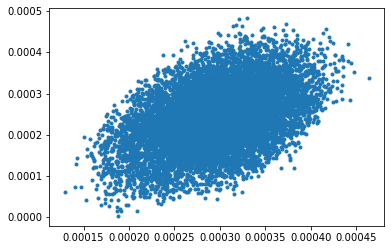

In [6]:
beam = model.beam()
fig,ax = plt.subplots()
ax.plot(beam.x.detach(), beam.y.detach(),".")